# Analytics Assignment

Let's peek at the data.

In [959]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [960]:
df = pd.read_csv('traffic_sample.csv')
df['_timestamp'] = pd.to_datetime(df['_timestamp'].str.replace(' UTC', '' ), format='%Y-%m-%d %H:%M:%S.%f')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877420 entries, 0 to 4877419
Data columns (total 7 columns):
_timestamp       datetime64[ns]
asn              object
ip               object
account          object
user_agent       object
fingerprint      object
is_successful    int64
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 260.5+ MB


* **_timestamp** - the date and time of the attempted login
* **asn** - the unique name of the system that attempted the login
* **ip** - the IP address of the machine that attempted the login
* **account** - the username used during the attempted login
* **user_agent** - the browser used during the attempted login
* **fingerprint** - the fingerprint of the attempted login
* **is_successful** - boolean indicating if the attempted login was successful

In [961]:
df.head()

,_timestamp,asn,ip,account,user_agent,fingerprint,is_successful
0,2019-02-26 23:59:53.795,Boar,4ed5.131.12.161,9jl+ubSARg,9f0a657d28,a6aa7e0552,0
1,2019-02-26 23:59:56.681,Blacktip Reef Shark,4ed5.89.55.222,tE9q8BwFG8,9f0a657d28,a6aa7e0552,0
2,2019-02-26 23:58:47.484,Caribou,12cf.87.176.70,H6vaD/O2rr,9f0a657d28,a6aa7e0552,0
3,2019-02-26 23:59:07.429,Bearded Dragon,fc4e.222.152.73,VQZMh1bCq8,9f0a657d28,a6aa7e0552,0
4,2019-02-26 23:59:47.459,Bird,21a8.113.225.114,yDSiAT2D82,9f0a657d28,a6aa7e0552,0


First, let's try to label some of the more egregious bot traffic.

If a username is being used to log in across a large number of IP addresses, it most likely means the username has been stolen, and if a device is attempting to log in with a stolen username, it is most likely a bot.

Let's figure out which usernames have been stolen.

In [962]:
df.groupby('account').agg({'ip':'nunique', 'asn':'nunique', 'user_agent':'nunique', 'fingerprint':'nunique', 'account':'count', 'is_successful':'sum', '_timestamp':'min'}).rename(columns={'ip':'unique_ip_count', 'asn':'unique_asn_count', 'user_agent':'unique_user_agent_count', 'fingerprint':'unique_fingerprint_count', 'account':'login_attempt_count', 'is_successful':'login_success_count', '_timestamp':'traffic_started_on'}).sort_values('unique_ip_count', ascending=False).head(100)

,unique_ip_count,unique_asn_count,unique_user_agent_count,unique_fingerprint_count,login_attempt_count,login_success_count,traffic_started_on
account,,,,,,,
47DEQpj8HB,920945,55,563,8,1820355,1812565,2019-02-25 00:00:00.090
H4zXlbnMEA,385676,56,5332,9,660241,610458,2019-02-25 00:00:00.356
MCdjQmonCz,9165,25,1895,1,11493,10678,2019-02-25 00:00:05.704
NygkDML5IM,4082,21,1064,1,4887,4572,2019-02-25 00:00:08.775
ZzFgMH1SU+,3745,23,958,1,4512,4228,2019-02-25 00:01:35.740
g6PvGc+0/2,3691,18,903,1,4455,4176,2019-02-25 00:00:46.130
h413jQNY8E,3326,21,890,1,3913,3665,2019-02-25 00:00:53.337
WjpRQmVo2S,3265,25,808,1,3779,3573,2019-02-25 00:00:10.666
2o+pV5+5xt,2984,21,758,1,3549,3326,2019-02-25 00:00:40.513


This looks...questionable. Could a single username really have been used by **1 million** different devices with such a high log in success rate? The assignment instructions indicate that the account column is just an **extract** of the full hash, so username '47DEQpj8HB' probably represents **many** unique usernames. So much for that.

In [963]:
df.groupby('account').agg({'ip':'nunique', 'asn':'nunique', 'user_agent':'nunique', 'fingerprint':'nunique', 'account':'count', 'is_successful':'sum', '_timestamp':'min'}).rename(columns={'ip':'unique_ip_count', 'asn':'unique_asn_count', 'user_agent':'unique_user_agent_count', 'fingerprint':'unique_fingerprint_count', 'account':'login_attempt_count', 'is_successful':'login_success_count', '_timestamp':'traffic_started_on'}).sort_values('unique_ip_count', ascending=False).tail()

,unique_ip_count,unique_asn_count,unique_user_agent_count,unique_fingerprint_count,login_attempt_count,login_success_count,traffic_started_on
account,,,,,,,
KcQ+dQVOcd,1,1,1,1,1,0,2019-02-27 06:53:14.984
KcPzOfXTMu,1,1,1,1,1,1,2019-02-27 20:20:11.505
KcOpv3JNqS,1,1,1,1,1,1,2019-02-26 00:39:23.631
KcOdC0wt3r,1,1,1,1,1,0,2019-02-26 14:15:39.317
zzzrHz8tpN,1,1,1,1,1,0,2019-02-26 01:21:33.765


In terms of unique IP counts, these look a lot more legit. Let's say that a username needs to have been used by 15 different ip addresses (5 per day) in order to qualify as stolen, and flag any ip addresses that have used it as bots.

In [964]:
#df = pd.merge(df, df.groupby('account').ip.nunique().loc[lambda x: x >= 15].rename('is_bot'), on='account', how='left')
#df.loc[df.is_bot > 0, 'is_bot'] = True
#df.is_bot.fillna(False, inplace=True)

In [965]:
#df.is_bot.value_counts()

Per tip #3 from our colleague, we should be able to label IP addresses that use large numbers of usernames *unsuccessfully* as bots.

In [966]:
ips = df.groupby('ip').agg({'account':'nunique', 'is_successful':'sum', 'ip':'count'}).rename(columns={'account':'unique_account_count', 'ip':'login_attempt_count', 'is_successful':'login_success_count'}).sort_values('unique_account_count', ascending=False)
ips['login_success_rate'] = ips.login_success_count / ips.login_attempt_count
ips.drop(['login_success_count', 'login_attempt_count'], axis=1, inplace=True)
ips['is_bot'] = (ips.unique_account_count >= 15.0) & (ips.login_success_rate <= 0.1)
df = pd.merge(df, ips[ips['is_bot'] == 1].is_bot, on='ip', how='left')
df.is_bot.fillna(False, inplace=True)
#df['is_bot'] = df.is_bot_x | df.is_bot_y
#df.drop(['is_bot_x', 'is_bot_y'], axis=1, inplace=True)


In [967]:
df.is_bot.value_counts()

False    4448690
True      428730
Name: is_bot, dtype: int64

Let's see if this traffic follows a non-diurnal pattern per tip #1.

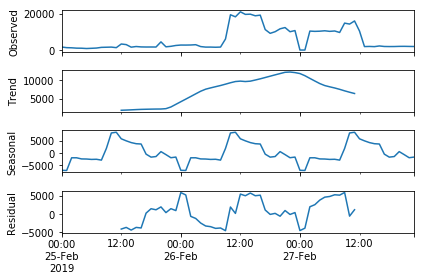

In [968]:
df.set_index(df['_timestamp'].dt.floor('h'), inplace=True)
result = seasonal_decompose(df[df['is_bot'] == True].index.value_counts().sort_index().asfreq('H', fill_value=0), model='additive')
result.plot()
plt.show()

Two hours of data are missing from 12am-1am on Feb 27, but even without, we can recognize this as a suspicious pattern. Let's look at the logins we have inversely identified as human.

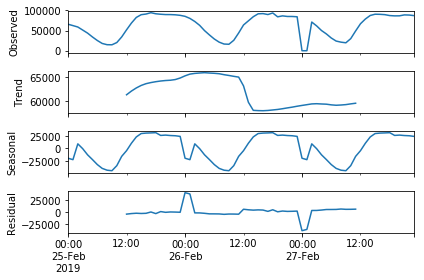

In [969]:
result = seasonal_decompose(df[df['is_bot'] == False].index.value_counts().sort_index().asfreq('H', fill_value=0), model='additive')
result.plot()
plt.show()

Despite the two missing ours, this is a diurnal pattern, so we're on the right track.

Tip #3 says that botnets use limited IP ranges. Let's get the login success rate by IP range.

In [970]:
df['ip_range'] = df['ip'].str.replace(r'\.\d+$', '')
ip_ranges = df.groupby('ip_range').agg({'ip':'nunique', 'account':'count', 'is_successful':'sum'}).rename(columns={'ip':'unique_ip_count', 'account':'login_attempt_count', 'is_successful':'login_success_count'}).sort_values('login_attempt_count', ascending=False)
ip_ranges['login_success_rate'] = ip_ranges.login_success_count / ip_ranges.login_attempt_count
ip_ranges.head()


,unique_ip_count,login_attempt_count,login_success_count,login_success_rate
ip_range,,,,
2606.58.21,256,45150,42117,0.932824
2606.58.12,256,28100,26089,0.928434
1466.171.81,94,26662,1,0.000038
708a.77.245,12,25421,22564,0.887613
2606.58.23,130,22713,21237,0.935015


In [971]:
ip_ranges['is_bot'] = (ip_ranges.login_attempt_count >= 15.0) & (ip_ranges.login_success_rate <= 0.1)
df = pd.merge(df, ip_ranges[ip_ranges['is_bot'] == 1].is_bot, on='ip_range', how='left')
df['is_bot'] = df.is_bot_x | df.is_bot_y
df.drop(['is_bot_x', 'is_bot_y'], axis=1, inplace=True)
df.is_bot.value_counts()

False    4420712
True      456708
Name: is_bot, dtype: int64

Not a significant gain, but worth the effort!

## 1. A list of signatures for the automated traffic.

In [972]:
df[df.is_bot == True].groupby(['asn', 'ip']).size()

asn       ip              
Aardvark  1466.171.107.102    178
          1466.171.107.103     87
          1466.171.107.104    365
          1466.171.107.105    152
          1466.171.107.110    407
          1466.171.107.111    230
          1466.171.107.112    124
          1466.171.107.113    271
          1466.171.107.118    248
          1466.171.107.119    359
          1466.171.107.120    119
          1466.171.107.121    526
          1466.171.107.126    116
          1466.171.107.127    190
          1466.171.107.128    103
          1466.171.107.129     69
          1466.171.107.134    362
          1466.171.107.135    131
          1466.171.107.136    192
          1466.171.107.137     87
          1466.171.107.240      1
          1466.171.107.241      1
          1466.171.107.46     268
          1466.171.107.47     330
          1466.171.107.48     258
          1466.171.107.49     109
          1466.171.107.54     148
          1466.171.107.55     242
          1466.171.10

## 2. A visualization of the traffic sample.

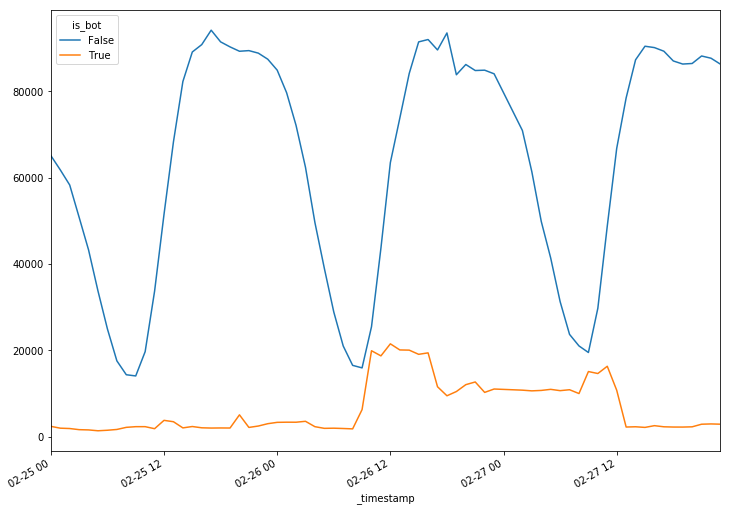

In [973]:
df.groupby([df['_timestamp'].dt.floor('h'),'is_bot']).count()['ip'].unstack().plot(subplots=False, figsize=(12, 9))

## 3a. What percentage of the traffic sample is automated traffic?

In [974]:
df.is_bot.value_counts(normalize=True)

False    0.906363
True     0.093637
Name: is_bot, dtype: float64

## 3b. What is the login success rate (i) Overall (ii) For human traffic (iii) For automated traffic

(i) Overall

In [975]:
logins = df.agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']



0.8310805712856387

(ii) For human traffic

In [976]:
logins = df[df.is_bot == False].agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']



0.9167437281596268

(iii) For automated traffic

In [977]:
logins = df[df.is_bot == True].agg({'ip':'count', 'is_successful':'sum'}).rename(columns={'ip':'login_attempt_count', 'is_successful':'login_success_count'})
logins.loc['is_successful'] / logins.loc['ip']

0.0019027474885484818

## 3c. What are the top (i) ASNs (ii) Fingerprints (iii) User agents for automated traffic?

(i) ASNS

In [978]:
df[df.is_bot == True].groupby('asn').count().sort_values('ip', ascending=False)['ip']

asn
Aardvark                 182031
Aardwolf                  85097
Anteater                  24431
Antelope                  17010
Bandicoot                  7994
Aye-Aye                    7721
Bearded Dragon             7291
Billy Goat                 6639
Bat                        6391
African Tree Pangolin      5765
Bison                      5692
Bird                       5538
Beluga Whale               5156
Ape                        4979
Blue Whale                 4876
Black Howler Monkey        4825
Black Rhino                4774
Bengal Tiger               3780
Blacktip Reef Shark        3439
Brown Bear                 3405
Caiman Lizard              3398
Bobcat                     3383
Camel                      3353
Bottlenose Whale           3319
Bull frog                  2903
Chimpanzee                 2867
Black Footed Rhino         2742
Common Dolphin             2730
Bull                       2683
Common Seal                2512
Boar                       2460
Bono

(ii) Fingerprints

In [979]:
df[df.is_bot == True].groupby('fingerprint').count().sort_values('ip', ascending=False)['ip']

fingerprint
f672c6ea9c    288647
a6aa7e0552     80254
b747f0cc00     65701
bb8c1fc381     18039
f6c6dae97c      1856
56e485800a       742
ebc1e6a4f8       544
c66d7ff0ea       389
5a6044dc6c       223
245f996195       186
57963cd951       113
d9888e2175         6
7f7d9648bd         3
9c0f6f6b2a         3
e4ab0181b9         2
Name: ip, dtype: int64

(iii) User agents

In [980]:
df[df.is_bot == True].groupby('user_agent').count().sort_values('ip', ascending=False)['ip']

user_agent
9f0a657d28    80832
c3de0d9a7c      332
7e57ff0758       63
cba4767ccc       35
e0c6f26634       35
3bfa188e99       35
8b1aba0808       34
2bfa0fc8ee       34
b4ffc05020       34
cb1d377cf7       33
8b457a5e50       33
4620e23beb       32
376e88d9a3       32
26f8c93632       32
39b38a9c57       31
c75e649b26       31
8e97c367b6       31
6b3cc6fd09       31
20035e58c0       30
d455b9ccad       30
8e8b6df1ee       30
f130e99724       30
ef80a5e774       30
e28eb7986d       30
be92e810dc       30
0a2334e7f7       30
a53fb7476b       30
68a8291023       30
73051ec61e       29
e44fa0ef90       29
              ...  
6b71aacae6        1
6b719733a8        1
6b6b93ece0        1
6b692666b4        1
6b690b7430        1
6b68f3edbf        1
6b689f33dc        1
6b67cfb20d        1
6b7d24a8d9        1
6b7e97c4a9        1
6b7ec75f52        1
6b7f05b3b8        1
6b90cc7e3d        1
6b90c13527        1
6b9042afa1        1
6b9036dd0e        1
6b8fa7f446        1
6b8ed59c63        1
6b8e3cf85

## Let's engineer features for our model

1. Automated traffic follows a non-diurnal pattern

As we have seen, automated traffic is more spread out across the daythan its human counterpart because humans sleep and robots do not. To capture the degree to which traffic varies throughout the day, we will calculate the hourly variance.

First, we need to extract the hour from the timestamp.

In [981]:
df['hour'] = df._timestamp.dt.hour

Done. Now we need to encode our new hour feature to reflect its cyclical nature. If we leave it as is, the variance calculation won't be accurate. The difference between midnight (0) and 11pm (23) isn't 23, it's 1! 

In [982]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = encode(df, 'hour', 24)
df[(df['hour'] == 0) | (df['hour'] == 23)].groupby('hour').agg({'hour_sin': 'max','hour_cos': 'max'})

,hour_sin,hour_cos
hour,,
0,0.000000,1.000000
23,-0.258819,0.965926


Our hour values are now represented by pairs of coordinates on a circle. The values for midnight (0) and 11pm (23) are now very close to each other in magnitude. *Now* we can calculate the variance.

In [1000]:
train_df = df.groupby('ip').agg({'is_bot': 'max', 'hour_sin': 'var', 'hour_cos': 'var'}).fillna(0.0)
train_df.head()


,is_bot,hour_sin,hour_cos
ip,,,
0222.110.101.9,True,0.571889,0.412448
0222.110.123.127,False,0.011455,0.338916
0222.110.144.37,False,0.004990,0.029084
0222.110.19.200,False,0.000000,0.000000
0222.110.51.241,True,0.532500,0.334137


Let's peek at a couple of these and see if they validate our assumptions. Higher values in the variance columns should correlate with non-diurnal login patterns.

High (0.571889, 0.412448)

In [1001]:
df[df['ip'] == '0222.110.101.9']['hour'].value_counts().sort_index()

1     2
2     2
5     2
6     1
7     1
8     2
13    1
16    1
17    1
19    1
22    1
Name: hour, dtype: int64

Low (0.011455, 0.338916)

In [1002]:
df[df['ip'] == '0222.110.123.127']['hour'].value_counts().sort_index()

15    1
16    1
19    1
20    1
Name: hour, dtype: int64

Success! Let's move on to the next feature.

## 2. Automated traffic volume has low variance over time

The volume of automated traffic tends to remain constant between the time it starts and the time it ends. Human traffic varies much more. A good metric for measuring this is the variance of the time between login attempts. Automated traffic should exhibit lower variance than human traffic.

$$𝑟𝑡=Δln𝑦𝑡≡ln𝑦𝑡−ln𝑦𝑡−1.$$


In [1003]:
#df_count = df.groupby(['ip', 'timestamp_hour']).ip.agg('count').to_frame('login_count').reset_index()[['ip', 'timestamp_hour', 'login_count']].sort_values(['ip', 'timestamp_hour'], ascending=True)
df['prev_ip'] = df.sort_values(['ip', '_timestamp'], ascending=True)['ip'].shift(1)
df['prev_timestamp'] = df.sort_values(['ip', '_timestamp'], ascending=True)['_timestamp'].shift(1)
df['timestamp_delta_var'] = (df[df['ip'] == df['prev_ip']]['_timestamp'] - df['prev_timestamp']).astype('timedelta64[s]')
train_df = pd.merge(train_df, df.groupby('ip').timestamp_delta_var.var().fillna(0), on='ip', how='left')
#df.groupby('ip').timestamp_delta.var().fillna(100)
#df[df['ip'] =='0222.110.101.9']

#df_count['login_count-1'] = df_count.login_count.shift(1).fillna(0)
#df_count['login_count_delta'] = (df_count[df_count['ip'] == df_count['ip-1']]['login_count'] - df_count[df_count['ip'] == df_count['ip-1']]['login_count-1']) / df_count[df_count['ip'] == df_count['ip-1']]['login_count-1']
#df_count['login_count_delta'].fillna(0, inplace=True)
#df_count[df_count['ip'] == 'fc4e.224.35.165']
#df_count = df_count.groupby('ip').login_count_delta.agg('var').fillna(0)
#df_count

## 3, 4 and 5. Automated traffic has: 1) High login volumes 2) High username volumes and 3) High rates of failure

In [1004]:
#1) High login volumes
train_df = pd.merge(train_df, df.groupby(['ip']).size().to_frame('login_attempt_count'), on='ip', how='left')

#2) High credential volumes
train_df = pd.merge(train_df, df.groupby(['ip'])['account'].nunique().to_frame('unique_username_count'), on='ip', how='left')

#3) High failure rates
train_df = pd.merge(train_df, df.groupby(['ip']).is_successful.sum().to_frame('login_success_count'), on='ip', how='left')

train_df['login_success_rate'] = train_df.login_success_count / train_df.login_attempt_count


In [1005]:
train_df.head()

,is_bot,hour_sin,hour_cos,timestamp_delta_var,login_attempt_count,unique_username_count,login_success_count,login_success_rate
ip,,,,,,,,
0222.110.101.9,True,0.571889,0.412448,1.643726e+08,15,15,0,0.0
0222.110.123.127,False,0.011455,0.338916,3.146537e+07,4,4,0,0.0
0222.110.144.37,False,0.004990,0.029084,0.000000e+00,2,2,0,0.0
0222.110.19.200,False,0.000000,0.000000,0.000000e+00,1,1,0,0.0
0222.110.51.241,True,0.532500,0.334137,6.852461e+07,23,23,0,0.0


In [1006]:
train_df.to_csv(path_or_buf='/Users/sthomas/Shape Security/training_data.csv', index=True)